In [117]:
import pandas as pd
import numpy as np
from sklearn.metrics import jaccard_score
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

# Disable future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def weighted_jaccard_similarity(matrix1, matrix2):
    """
    Compute the Weighted Jaccard Similarity between two adjacency matrices.
    """
    # Ensure matrices are numpy arrays for element-wise operations
    matrix1 = np.array(matrix1)
    matrix2 = np.array(matrix2)

    # Calculate the minimum (intersection) and maximum (union) for each element
    min_matrix = np.minimum(matrix1, matrix2)
    max_matrix = np.maximum(matrix1, matrix2)

    # Sum the weights for intersection and union
    intersection_weight_sum = np.sum(min_matrix)
    union_weight_sum = np.sum(max_matrix)

    # Compute the similarity
    similarity = intersection_weight_sum / union_weight_sum if union_weight_sum != 0 else 0
    return similarity


def prepare_edge_list(edge1, edge2):

    matrix1 = edge1.pivot(index ='source', columns='target', values='weight')
    matrix1 = matrix1.fillna(0)

    matrix2 = edge2.pivot(index ='source', columns='target', values='weight')
    matrix2 = matrix2.fillna(0)

    labels1 = list(matrix1.index)
    labels2 = list(matrix2.index)
    common_labels = set(labels1).intersection(set(labels2))

    matrix1 = matrix1[common_labels]
    matrix1 = matrix1.reset_index()
    matrix1 = matrix1[matrix1['source'].isin(common_labels)]
    matrix1 = matrix1.set_index('source')

    matrix2 = matrix2[common_labels]
    matrix2 = matrix2.reset_index()
    matrix2 = matrix2[matrix2['source'].isin(common_labels)]
    matrix2 = matrix2.set_index('source')

    matrix1 = matrix1.loc[common_labels, common_labels]
    matrix2 = matrix2.loc[common_labels, common_labels]

    return matrix1, matrix2


def compute_jaccar_simlarity(matrix1, matrix2):

    def replace_with_one(x):
        return 1 if x >= 1 else x

    matrix1_1 = matrix1.applymap(replace_with_one)
    matrix2_1 = matrix2.applymap(replace_with_one)

    score = jaccard_score(matrix1_1.to_numpy(), matrix2_1.to_numpy(), average='weighted')
    weighted_score = weighted_jaccard_similarity(matrix1, matrix2)

    return score, weighted_score


In [118]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
import numpy as np
from scipy.spatial import distance

"""edge1 = pd.read_csv('../networks/matrix/global_weighted.csv', index_col=[0])
edge1 = edge1[['source', 'target', 'weight']]

edge2 = pd.read_csv('../networks/matrix/non_europe_before_1700.csv', index_col=[0])
edge2 = edge2[['source', 'target', 'weight']]


matrix1, matrix2 = prepare_edge_list(edge1, edge2)

#score = jaccard_score(matrix1.to_numpy(), matrix2.to_numpy(), average='weighted')
matrix1, matrix2  = matrix1.to_numpy(), matrix2.to_numpy()


# Compute distances
euclidean_distance = distance.euclidean(matrix1.flatten(), matrix2.flatten())
manhattan_distance = distance.cityblock(matrix1.flatten(), matrix2.flatten())
cosine_distance = distance.cosine(matrix1.flatten(), matrix2.flatten())
jaccard_distance = distance.jaccard(matrix1.flatten(), matrix2.flatten())"""


"edge1 = pd.read_csv('../networks/matrix/global_weighted.csv', index_col=[0])\nedge1 = edge1[['source', 'target', 'weight']]\n\nedge2 = pd.read_csv('../networks/matrix/non_europe_before_1700.csv', index_col=[0])\nedge2 = edge2[['source', 'target', 'weight']]\n\n\nmatrix1, matrix2 = prepare_edge_list(edge1, edge2)\n\n#score = jaccard_score(matrix1.to_numpy(), matrix2.to_numpy(), average='weighted')\nmatrix1, matrix2  = matrix1.to_numpy(), matrix2.to_numpy()\n\n\n# Compute distances\neuclidean_distance = distance.euclidean(matrix1.flatten(), matrix2.flatten())\nmanhattan_distance = distance.cityblock(matrix1.flatten(), matrix2.flatten())\ncosine_distance = distance.cosine(matrix1.flatten(), matrix2.flatten())\njaccard_distance = distance.jaccard(matrix1.flatten(), matrix2.flatten())"

In [119]:
"""import glob


main_path = '../networks/matrix/'
paths = glob.glob(f'{main_path}*')

datasets ={}

for path in paths:
    try:

        mat = pd.read_csv(path, index_col=[0])
        name = path.split(main_path)[1].split('.csv')[0]

        if name in  ['europe_before_1700', 'non_europe_before_1700', 'weighted']:
            datasets[name] = mat
    except:
        pass

print(list(datasets.keys()))"""

"import glob\n\n\nmain_path = '../networks/matrix/'\npaths = glob.glob(f'{main_path}*')\n\ndatasets ={}\n\nfor path in paths:\n    try:\n\n        mat = pd.read_csv(path, index_col=[0])\n        name = path.split(main_path)[1].split('.csv')[0]\n\n        if name in  ['europe_before_1700', 'non_europe_before_1700', 'weighted']:\n            datasets[name] = mat\n    except:\n        pass\n\nprint(list(datasets.keys()))"

In [120]:
# Load non_europe

import networkx as nx

import pickle


def process_pickle_object(g):

    pos = nx.spring_layout(g, seed = 41)
    occupations = list(g.nodes())

    similarity_matrix = np.zeros((len(occupations), len(occupations)))

    for i, occupation_i in enumerate(occupations):
        for j, occupation_j in enumerate(occupations):
            pos_i = pos[occupation_i].reshape(1, -1)
            pos_j = pos[occupation_j].reshape(1, -1)
            similarity_matrix[i][j] = cosine_similarity(pos_i, pos_j)

    # Create a DataFrame from the similarity matrix
    similarity_df = pd.DataFrame(similarity_matrix, index=occupations, columns=occupations)
    edge_list_distance = similarity_df.stack().reset_index()
    edge_list_distance.columns = ['source', 'target', 'weight']

    return edge_list_distance


with open('../networks/g_objects/g_non_europe.pkl', 'rb') as file:
    g_non_europe = pickle.load(file)

with open('../networks/g_objects/g_europe.pkl', 'rb') as file:
    g_europe = pickle.load(file)

datasets = {}
datasets['non_europe_before_1700'] = process_pickle_object(g_non_europe)
datasets['europe_before_1700'] = process_pickle_object(g_europe)
datasets['weighted'] = pd.read_csv('../networks/matrix/weighted.csv', index_col=[0])

In [121]:
"""for element in datasets.keys():
    min_weight = datasets[element]['weight'].min()
    max_weight = datasets[element]['weight'].max()
    datasets[element]['weight'] = (datasets[element]['weight'] - min_weight) / (max_weight - min_weight)
# compute the distance"""

"for element in datasets.keys():\n    min_weight = datasets[element]['weight'].min()\n    max_weight = datasets[element]['weight'].max()\n    datasets[element]['weight'] = (datasets[element]['weight'] - min_weight) / (max_weight - min_weight)\n# compute the distance"

In [122]:
"""edge_list_distance["rank_count"] = edge_list_distance.groupby(["source"])["weight"].rank(
        method="first", ascending=False
    )

min_weight = edge_list_distance['weight'].min()
max_weight = edge_list_distance['weight'].max()
edge_list_distance['weight'] = (edge_list_distance['weight'] - min_weight) / (max_weight - min_weight)
edge_list_distance = edge_list_distance[
        edge_list_distance["source"] != edge_list_distance["target"]]
edge_list_distance = edge_list_distance[edge_list_distance['rank_count']<=15]

#finla_matrix = edge_list_distance.pivot()"""

'edge_list_distance["rank_count"] = edge_list_distance.groupby(["source"])["weight"].rank(\n        method="first", ascending=False\n    )\n\nmin_weight = edge_list_distance[\'weight\'].min()\nmax_weight = edge_list_distance[\'weight\'].max()\nedge_list_distance[\'weight\'] = (edge_list_distance[\'weight\'] - min_weight) / (max_weight - min_weight)\nedge_list_distance = edge_list_distance[\n        edge_list_distance["source"] != edge_list_distance["target"]]\nedge_list_distance = edge_list_distance[edge_list_distance[\'rank_count\']<=15]\n\n#finla_matrix = edge_list_distance.pivot()'

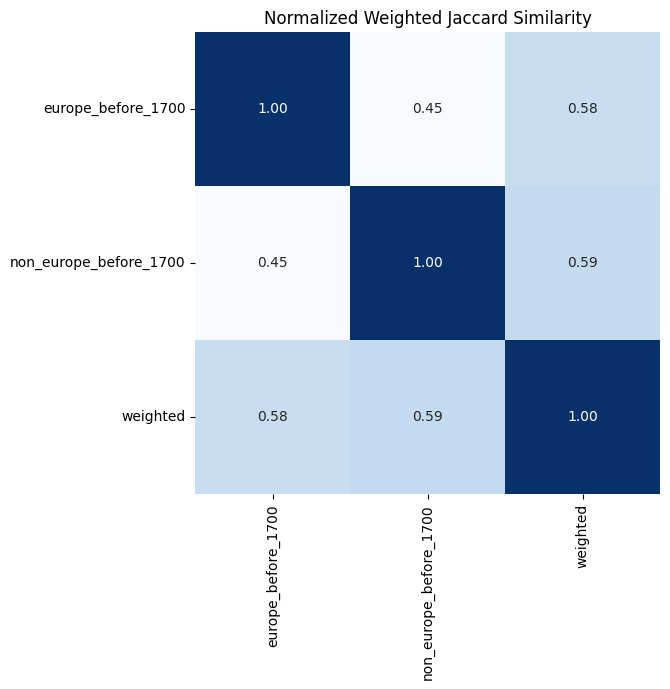

In [123]:
# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in datasets.items():
    for dataset2_name, dataset2 in datasets.items():
        # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
        dataset2 = dataset2[['source', 'target', 'weight']]
        dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
        try:
            score = round(score, 2)
        except:
            score = score
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

# Print or analyze the ARI values as needed
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')
plt.figure(figsize=(6, 6))
sns.heatmap(matrix_df.astype(float), cmap='Blues', annot=True, fmt=".2f", cbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Normalized Weighted Jaccard Similarity')
plt.show()

In [124]:
"""# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in datasets.items():
    for dataset2_name, dataset2 in datasets.items():
        # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset2 = dataset2[['source', 'target', 'weight']]

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = distance.euclidean(matrix1.flatten(), matrix2.flatten())
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

# Print or analyze the ARI values as needed
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')
# Scale the entire DataFrame
scaled_df = (matrix_df - matrix_df.min().min()) / (matrix_df.max().max() - matrix_df.min().min())
scaled_df = 1 - scaled_df
plt.figure(figsize=(6, 6))
sns.heatmap(scaled_df.astype(float), cmap='Blues', annot=True, fmt=".2f", cbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Euclidean Similarity')
plt.show()"""

'# Create an empty DataFrame to store the ARI values\nari_df = pd.DataFrame(columns=[\'Dataset 1\', \'Dataset 2\', \'metric\'])\n\n# Iterate over pairs of datasets and compute the ARI\nfor dataset1_name, dataset1 in datasets.items():\n    for dataset2_name, dataset2 in datasets.items():\n        # Get the common elements based on the \'node\' column\n\n        dataset1 = dataset1[[\'source\', \'target\', \'weight\']]\n        dataset2 = dataset2[[\'source\', \'target\', \'weight\']]\n\n        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)\n        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()\n\n        score = distance.euclidean(matrix1.flatten(), matrix2.flatten())\n        ari_df = ari_df.append({\'Dataset 1\': dataset1_name, \'Dataset 2\': dataset2_name, \'metric\': score}, ignore_index=True)\n\n# Print or analyze the ARI values as needed\nmatrix_df = ari_df.pivot(index=\'Dataset 1\', columns=\'Dataset 2\', values=\'metric\')\n# Scale the entire DataFrame\nsc

In [125]:
"""# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in datasets.items():
    for dataset2_name, dataset2 in datasets.items():
        # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset2 = dataset2[['source', 'target', 'weight']]

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = distance.cityblock(matrix1.flatten(), matrix2.flatten())
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

# Print or analyze the ARI values as needed
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')
scaled_df = (matrix_df - matrix_df.min().min()) / (matrix_df.max().max() - matrix_df.min().min())
scaled_df = 1 - scaled_df
plt.figure(figsize=(6, 6))
sns.heatmap(scaled_df.astype(float), cmap='Blues', annot=True, fmt=".2f", cbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Manhattan Similarity')
plt.show()
            """

'# Create an empty DataFrame to store the ARI values\nari_df = pd.DataFrame(columns=[\'Dataset 1\', \'Dataset 2\', \'metric\'])\n\n# Iterate over pairs of datasets and compute the ARI\nfor dataset1_name, dataset1 in datasets.items():\n    for dataset2_name, dataset2 in datasets.items():\n        # Get the common elements based on the \'node\' column\n\n        dataset1 = dataset1[[\'source\', \'target\', \'weight\']]\n        dataset2 = dataset2[[\'source\', \'target\', \'weight\']]\n\n        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)\n        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()\n\n        score = distance.cityblock(matrix1.flatten(), matrix2.flatten())\n        ari_df = ari_df.append({\'Dataset 1\': dataset1_name, \'Dataset 2\': dataset2_name, \'metric\': score}, ignore_index=True)\n\n# Print or analyze the ARI values as needed\nmatrix_df = ari_df.pivot(index=\'Dataset 1\', columns=\'Dataset 2\', values=\'metric\')\nscaled_df = (matrix_df - matrix_

In [126]:
"""# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in datasets.items():
    for dataset2_name, dataset2 in datasets.items():
            # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset2 = dataset2[['source', 'target', 'weight']]

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = distance.cosine(matrix1.flatten(), matrix2.flatten())
        score = round(score,2)
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

# Print or analyze the ARI values as needed
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')
scaled_df = (matrix_df - matrix_df.min().min()) / (matrix_df.max().max() - matrix_df.min().min())
scaled_df = 1 - scaled_df
plt.figure(figsize=(6, 6))
sns.heatmap(scaled_df.astype(float), cmap='Blues', annot=True, fmt=".2f", cbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Cosine Similarity')
plt.show()"""

'# Create an empty DataFrame to store the ARI values\nari_df = pd.DataFrame(columns=[\'Dataset 1\', \'Dataset 2\', \'metric\'])\n\n# Iterate over pairs of datasets and compute the ARI\nfor dataset1_name, dataset1 in datasets.items():\n    for dataset2_name, dataset2 in datasets.items():\n            # Get the common elements based on the \'node\' column\n\n        dataset1 = dataset1[[\'source\', \'target\', \'weight\']]\n        dataset2 = dataset2[[\'source\', \'target\', \'weight\']]\n\n        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)\n        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()\n\n        score = distance.cosine(matrix1.flatten(), matrix2.flatten())\n        score = round(score,2)\n        ari_df = ari_df.append({\'Dataset 1\': dataset1_name, \'Dataset 2\': dataset2_name, \'metric\': score}, ignore_index=True)\n\n# Print or analyze the ARI values as needed\nmatrix_df = ari_df.pivot(index=\'Dataset 1\', columns=\'Dataset 2\', values=\'metric\')\

In [127]:
ari_df

,Dataset 1,Dataset 2,metric
0,non_europe_before_1700,non_europe_before_1700,1.0
1,non_europe_before_1700,europe_before_1700,0.45
2,non_europe_before_1700,weighted,0.59
3,europe_before_1700,non_europe_before_1700,0.45
4,europe_before_1700,europe_before_1700,1.0
5,europe_before_1700,weighted,0.58
6,weighted,non_europe_before_1700,0.59
7,weighted,europe_before_1700,0.58
8,weighted,weighted,1.0


In [128]:
'''# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in datasets.items():
    for dataset2_name, dataset2 in datasets.items():
        # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset2 = dataset2[['source', 'target', 'weight']]

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
        try:
            score = round(score, 2)
        except:
            score = score
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

# Print or analyze the ARI values as needed
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')
plt.figure(figsize=(6, 6))
sns.heatmap(matrix_df.astype(float), cmap='Blues', annot=True, fmt=".2f", cbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Weighted Jaccard Similarity')

plt.show()
            '''

'# Create an empty DataFrame to store the ARI values\nari_df = pd.DataFrame(columns=[\'Dataset 1\', \'Dataset 2\', \'metric\'])\n\n# Iterate over pairs of datasets and compute the ARI\nfor dataset1_name, dataset1 in datasets.items():\n    for dataset2_name, dataset2 in datasets.items():\n        # Get the common elements based on the \'node\' column\n\n        dataset1 = dataset1[[\'source\', \'target\', \'weight\']]\n        dataset2 = dataset2[[\'source\', \'target\', \'weight\']]\n\n        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)\n        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()\n\n        score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())\n        try:\n            score = round(score, 2)\n        except:\n            score = score\n        ari_df = ari_df.append({\'Dataset 1\': dataset1_name, \'Dataset 2\': dataset2_name, \'metric\': score}, ignore_index=True)\n\n# Print or analyze the ARI values as needed\nmatrix_df = ari_d